In [236]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from typing import List, Tuple, Dict

from evaluate_prf1 import prf1_sweep

In [237]:
results_dir = "/home/masonbp/results/submap_align/kmd_outdoor/04_clip/"
robots = ['sparkal1', 'sparkal2', 'acl_jackal', 'acl_jackal2', 'thoth', 'hathor']
line_styles = [':', '--', '-.']

methods = ["01_semanticvolgrav"]
sub_dirs = [x[0] for x in os.walk(results_dir)][1:]
req_overlap = 0.25

In [238]:
def plot_success_rate(methods: List[str], percent_correct: Dict[str, List[float]], req_err_ang_dist_pairs: np.array, full_names={}, colors={}, styles={}, legend=True):
    ax = plt.gca()
    
    for method in methods:
        # set the seed with the method name
        np.random.seed(hash(method) % 2**32)
        
        if method not in full_names:
            full_names[method] = method
        if method not in colors:
            colors[method] = np.random.rand(3)
        if method not in styles:
            styles[method] = np.random.choice(line_styles)
    
    for i, method in enumerate(methods):
        ax.plot(req_err_ang_dist_pairs[:,0], percent_correct[method], label=full_names[method], linestyle=styles[method], color=colors[method])

    ax.set_ylabel('Percent Correct Transformation')
    ax.set_xlabel('Angular Error Threshold (deg)')
    ax_cp = ax.twiny()
    ax_cp.set_xlim(ax.get_xlim())
    ax_cp.set_xticks(req_err_ang_dist_pairs[:,0])
    ax_cp.set_xticklabels(req_err_ang_dist_pairs[:,1])
    ax_cp.set_xlabel('Distance Error Threshold (m)')
    if legend:
        ax.legend()
    
def reg_accuracy_sweep(pkl_paths, req_overlap=0.5, go_up_to_5=False, min_angle=60.0, max_angle=180.0):
    load_success = False
    for i, pkl_path in enumerate(pkl_paths):
        try:
            pkl_file = open(pkl_path, 'rb')
        except:
            print(f"Could not open {pkl_path}")
            continue
        if not load_success:
            load_success = True
            overlap_mat, err_ang_mat, err_dist_mat, num_assoc_mat, yaw_diff_mat = pickle.load(pkl_file)
            overlap_mat = np.reshape(overlap_mat, (-1,1))
            err_ang_mat = np.reshape(err_ang_mat, (-1,1))
            err_dist_mat = np.reshape(err_dist_mat, (-1,1))
            num_assoc_mat = np.reshape(num_assoc_mat, (-1,1))
            yaw_diff_mat = np.reshape(yaw_diff_mat, (-1,1))
        else:
            om, eam, edm, nam, ydm = pickle.load(pkl_file)
            overlap_mat = np.concatenate((overlap_mat, np.reshape(om, (-1,1))), axis=0)
            err_ang_mat = np.concatenate((err_ang_mat, np.reshape(eam, (-1,1))), axis=0)
            err_dist_mat = np.concatenate((err_dist_mat, np.reshape(edm, (-1,1))), axis=0)
            num_assoc_mat = np.concatenate((num_assoc_mat, np.reshape(nam, (-1,1))), axis=0)
            yaw_diff_mat = np.concatenate((yaw_diff_mat, np.reshape(ydm, (-1,1))), axis=0)
    
    if not load_success:
        raise FileNotFoundError("Could not load any of the pkl files")
    req_err_ang_dist_pairs = np.array([
        # (0.25, 0.125),
        (0.5, 0.25),
        (1.0, 0.5),
        (1.5, 0.75),
        (2.0, 1.0),
        (2.5, 1.25),
        (3.0, 1.5),
    ])
    if go_up_to_5:
        req_err_ang_dist_pairs = np.concatenate((req_err_ang_dist_pairs, np.array([
            (4.0, 2.0),
            (5.0, 2.5),
            (6.0, 3.0),
            (7.0, 3.5),
            (8.0, 4.0),
            (9.0, 4.5),
            (10.0, 5.0),
        ])))
    
    correct_loc = []
    relevant_alignments = np.bitwise_and(np.bitwise_and(
        overlap_mat > req_overlap, yaw_diff_mat > min_angle), yaw_diff_mat < max_angle)
    total_loc = np.sum(relevant_alignments)
    for req_err_ang, req_err_dist in req_err_ang_dist_pairs:
        correct_loc.append(np.sum(relevant_alignments & (err_ang_mat < req_err_ang) & (err_dist_mat < req_err_dist)))
        # correct_loc.append(np.sum(np.bitwise_and(np.bitwise_and(relevant_alignments, (err_ang_mat < req_err_ang)), (err_dist_mat < req_err_dist))))
    
    return (np.array(correct_loc) / total_loc), total_loc, req_err_ang_dist_pairs

In [239]:
success_rate = dict()
for method in methods:
    pkl_paths = [f"{sub_dir}/{method}.pkl" for sub_dir in sub_dirs]
    to_rm = []
    for i, sd in enumerate(sub_dirs):
        robot_combinations = sd.split('/')[-1]
        for robot in robots:
            if robot_combinations.count(robot) == 2:
                to_rm.append(i)
                break
    for i in sorted(to_rm, reverse=True):
        del pkl_paths[i]

    try:
        pc_meth, total_loc, req_err_ang_dist_pairs = reg_accuracy_sweep(pkl_paths, req_overlap=req_overlap, go_up_to_5=True, min_angle=120.0, max_angle=180.0)
        success_rate[method] = pc_meth
    except FileNotFoundError:
        print(f"Failed to load {method}")

print(success_rate)

yeah...
{'01_semanticvolgrav': array([0.        , 0.        , 0.02469136, 0.02880658, 0.04115226,
       0.04115226, 0.0617284 , 0.07407407])}


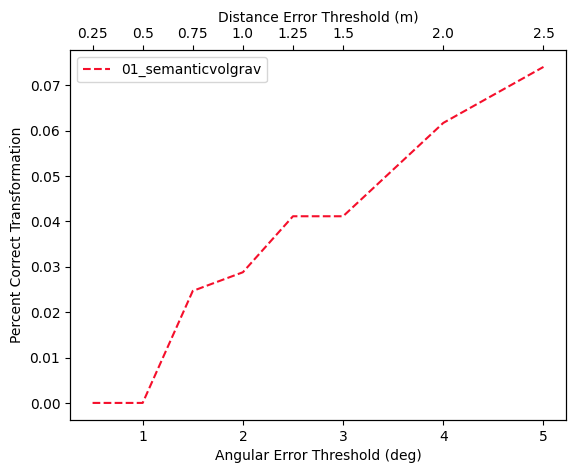

In [240]:
fig, ax = plt.subplots()

found_methods = [method for method in methods if method in success_rate]
plot_success_rate(found_methods, success_rate, req_err_ang_dist_pairs, legend=True)
# ax.set_xlabel('Recall')
# ax.set_ylabel('Precision')
ax.legend()
# plt.show()
# plt.savefig("/home/masonbp/figs/outdoor_global_loc_rss24/kmd_pr.pdf")
plt.show()